In [39]:
import numpy as np
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import CGConv
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
import argparse
import pickle
from models import simpleNet, comp1Net, comp2Net
from util import get_loss, get_plot
from statistics import stdev
from mendeleev import get_table

In [40]:
from mendeleev import element

In [41]:
ptable = get_table('elements')
cols = ['dipole_polarizability', 'vdw_radius_uff','en_pauling','covalent_radius_cordero','electron_affinity','atomic_volume']

In [42]:
ptable[cols][:86]

,dipole_polarizability,vdw_radius_uff,en_pauling,covalent_radius_cordero,electron_affinity,atomic_volume
0,4.50711,288.6,2.20,31.0,0.754195,14.1
1,1.38375,236.2,NaN,28.0,-19.700000,31.8
2,164.11250,245.1,0.98,128.0,0.618049,13.1
3,37.74000,274.5,1.57,96.0,-2.400000,5.0
4,20.50000,408.3,2.04,84.0,0.279723,4.6
...,...,...,...,...,...,...
81,47.00000,429.7,1.80,146.0,0.356743,18.3
82,48.00000,437.0,1.90,148.0,0.942362,21.3
83,44.00000,470.9,2.00,140.0,1.900000,22.7
84,42.00000,475.0,2.20,150.0,2.800000,NaN


In [48]:
allfeatures = []
for i in range(1,87):
    features = []
    ele = element(i)
    features.append(ele.symbol)
    features.append(ele.dipole_polarizability)
    features.append(ele.vdw_radius_uff)
    features.append(ele.en_pauling)
    features.append(ele.covalent_radius_cordero)
    features.append(ele.nvalence())
    features.append(ele.ionenergies[1])
    features.append(ele.electron_affinity)   
    features.append(ele.atomic_volume)
    allfeatures.append(features)
allfeatures = np.array(allfeatures)
allfeatures

array([['H', 4.50711, 288.6, 2.2, 31.0, 1, 13.598434005136, 0.754195,
        14.1],
       ['He', 1.38375, 236.20000000000002, None, 28.000000000000004, 2,
        24.587387936, -19.7, 31.8],
       ['Li', 164.1125, 245.1, 0.98, 128.0, 1, 5.391714761, 0.618049,
        13.1],
       ['Be', 37.74, 274.5, 1.57, 96.0, 2, 9.322699, -2.4, 5.0],
       ['B', 20.5, 408.3, 2.04, 84.0, 3, 8.298019, 0.279723, 4.6],
       ['C', 11.3, 385.1, 2.55, 73.0, 4, 11.260296, 1.262119, 5.3],
       ['N', 7.4, 366.0, 3.04, 71.0, 5, 14.53413, -1.4, 17.3],
       ['O', 5.3, 350.0, 3.44, 66.0, 6, 13.618054, 1.4611135, 14.0],
       ['F', 3.74, 336.4, 3.98, 56.99999999999999, 7, 17.42282,
        3.4011897000000006, 17.1],
       ['Ne', 2.6611, 324.3, None, 57.99999999999999, 8, 21.56454, None,
        16.8],
       ['Na', 162.7, 298.3, 0.93, 166.0, 1, 5.1390767, 0.547926, 23.7],
       ['Mg', 71.2, 302.1, 1.31, 141.0, 2, 7.646235, None, 14.0],
       ['Al', 57.8, 449.9, 1.61, 121.0, 3, 5.9857684, 0.43283, 10

In [49]:
allfeatures = []
for i in range(1,87):
    features = []
    ele = element(i)
    features.append(ele.dipole_polarizability)
    features.append(ele.vdw_radius_uff)
    features.append(ele.en_pauling)
    features.append(ele.covalent_radius_cordero)
    features.append(ele.nvalence())
    features.append(ele.ionenergies[1])
    features.append(ele.electron_affinity)   
    features.append(ele.atomic_volume)
    allfeatures.append(features)
allfeatures = np.array(allfeatures)
allfeatures

array([[4.50711, 288.6, 2.2, 31.0, 1, 13.598434005136, 0.754195, 14.1],
       [1.38375, 236.20000000000002, None, 28.000000000000004, 2,
        24.587387936, -19.7, 31.8],
       [164.1125, 245.1, 0.98, 128.0, 1, 5.391714761, 0.618049, 13.1],
       [37.74, 274.5, 1.57, 96.0, 2, 9.322699, -2.4, 5.0],
       [20.5, 408.3, 2.04, 84.0, 3, 8.298019, 0.279723, 4.6],
       [11.3, 385.1, 2.55, 73.0, 4, 11.260296, 1.262119, 5.3],
       [7.4, 366.0, 3.04, 71.0, 5, 14.53413, -1.4, 17.3],
       [5.3, 350.0, 3.44, 66.0, 6, 13.618054, 1.4611135, 14.0],
       [3.74, 336.4, 3.98, 56.99999999999999, 7, 17.42282,
        3.4011897000000006, 17.1],
       [2.6611, 324.3, None, 57.99999999999999, 8, 21.56454, None, 16.8],
       [162.7, 298.3, 0.93, 166.0, 1, 5.1390767, 0.547926, 23.7],
       [71.2, 302.1, 1.31, 141.0, 2, 7.646235, None, 14.0],
       [57.8, 449.9, 1.61, 121.0, 3, 5.9857684, 0.43283, 10.0],
       [37.3, 429.5, 1.9, 111.00000000000001, 4, 8.151683, 1.3895211,
        12.1],
      

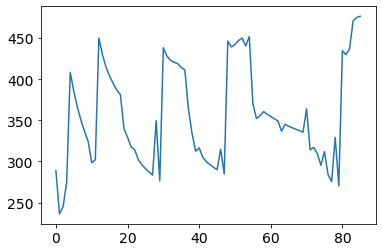

In [50]:
plt.plot(allfeatures[:,1])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(allfeatures)

StandardScaler()

In [52]:
scaler.fit(allfeatures)

StandardScaler()

In [53]:
allfeatures_ = scaler.transform(allfeatures)

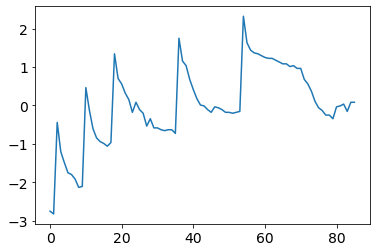

In [54]:
plt.plot(allfeatures_[:,3])

In [61]:
all_atomic_features = []
grpes = []
for i in range(1,87):
    features = []
    ele = element(i)
    features.append(ele.dipole_polarizability)
    features.append(ele.vdw_radius_uff)
    features.append(ele.en_pauling)
    features.append(ele.covalent_radius_cordero)
    features.append(ele.nvalence())
    features.append(ele.ionenergies[1])
    features.append(ele.electron_affinity)
    features.append(ele.atomic_volume)
    all_atomic_features.append(features)
all_atomic_features = np.array(all_atomic_features)

scaler = StandardScaler()
scaler.fit(all_atomic_features)
all_atomic_features = scaler.transform(all_atomic_features)
all_atomic_features

array([[-1.07102504e+00, -1.11034803e+00,  6.29006114e-01,
        -2.74559897e+00, -1.31810247e+00,  1.50588517e+00,
         1.04177892e-01, -3.15649362e-01],
       [-1.11051732e+00, -1.98058219e+00,             nan,
        -2.81692759e+00, -9.96066074e-01,  4.66432531e+00,
        -6.85711619e+00,  1.29549815e+00],
       [ 9.47052148e-01, -1.83277525e+00, -1.30389655e+00,
        -4.39306894e-01, -1.31810247e+00, -8.52886331e-01,
         5.78425389e-02, -4.06674646e-01],
       [-6.50822830e-01, -1.34451410e+00, -3.69132145e-01,
        -1.20014552e+00, -9.96066074e-01,  2.76955368e-01,
        -9.69307473e-01, -1.14397944e+00],
       [-8.68808267e-01,  8.77572368e-01,  3.75510683e-01,
        -1.48546000e+00, -6.74029674e-01, -1.75576909e-02,
        -5.73018988e-02, -1.18038955e+00],
       [-9.85134602e-01,  4.92277854e-01,  1.18352737e+00,
        -1.74699828e+00, -3.51993274e-01,  8.33858614e-01,
         2.77042594e-01, -1.11667186e+00],
       [-1.03444685e+00,  1.750741

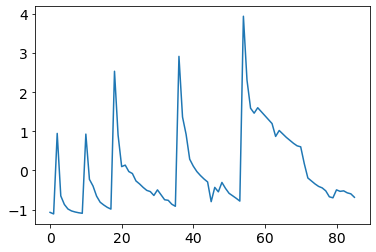

In [63]:
plt.plot(all_atomic_features[:,0])